# Advanced Tutorial for Basis Set

In the examples of 'input_and_basisset', basic setups of basis set has been introduced. Here are examples to explain the structure of basis set objects used in CRYSTALpytools to help customizing and testing basis sets.

Basis set converison highly depends on the [Basis Set Exchange (BSE) Python API](https://molssi-bse.github.io/basis_set_exchange/index.html). But for the optimal compatibility, CRYSTALpytools has its own classes and I/O methods for the CRYSTAL basis set format.

Please read 'input and basisset' example cases for basic usages before you start with this one.

## 'base.basisset.AtomBS' class

### Attributes

The basic basis set class of an element (of conventional atomic number) is defined by the `AtomBS` class, which as 5 attributes:

1. `z`: Conventional atomic number, following the rules of CRYSTAL.  
2. `nshell`: Number of BS shells.  
3. `ECP`: Formatted string of effective core pseudopotenital, to be printed before basis set definition.  
4. `element`: `mendeleev.element` object.  
5. `shells`: Basis set definition, see below.

In [1]:
from CRYSTALpytools.base.basisset import AtomBS, BasisSetBASE

c = BasisSetBASE.from_bse('6-31G*', z=[6]).atoms[0]
print(c.__dict__.keys())

dict_keys(['z', 'nshell', 'ECP', 'element', 'shells'])


The `shells` attribute is a list of atomic orbital shells, each of which corresponds to a certain angular momentum and consists of at least 1 Gaussian type orbitals (GTO). 

Here the angular momentum of every shell of the 6-31G\* C atom is printed:

In [2]:
for s in c.shells:
    print(s['angular momentum'])

0
1
1
3


As indicated by the case, every shell is defined by a dictionary, whose keys include:

- 'type': The 'ITYB' parameter of CRYSTAL basis set, i.e., type of basis set.  
- 'angular momentum': 'LAT', shell type (s, sp, p, d, ...).  
- 'n orbital': 'NG', number of GTOs.  
- 'charge': 'CHE', formal charge, initial guess.  
- 'scale factor': 'SCAL', almost obsolete, scale factor of the shell.  
- 'orbitals': GTO definition.

The first 5 keys correspond to the first line of every shell definition and the 'orbitals' key corresponds to the nGTO\*2 or nGTO\*3 (sp shell) list / array of exponent, coefficient and contract factors.

Check the parameters of the first sp shell and compare its s and p components.

[[ 7.86827235 -0.11933242  0.06899907]
 [ 1.88128854 -0.16085415  0.31642396]
 [ 0.54424926  1.14345644  0.74430829]]


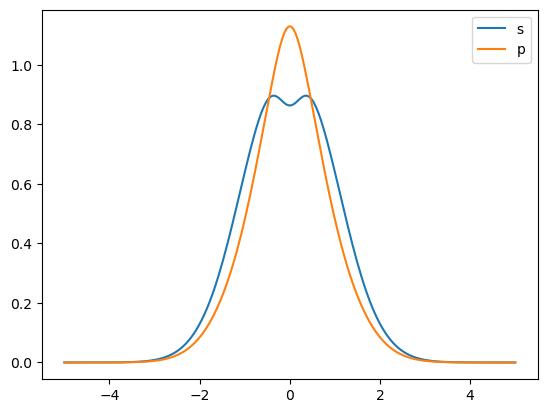

In [3]:
import numpy as np
import matplotlib.pyplot as plt

print(c.shells[1]['orbitals'])

x = np.linspace(-5, 5, 200)
ys = 0.
yp = 0.
for i in c.shells[1]['orbitals']:
    ys += i[1]*np.exp(-i[0]*x**2)
    yp += i[2]*np.exp(-i[0]*x**2)

plt.plot(x, np.vstack([ys, yp]).transpose(), label=['s', 'p'])
plt.legend()

### Assign charge

Basis sets from BSE do not contain charge information. A method is developed to automatically assign charge based on nuclear atomic charge, which has been tested on both all-electron and (less comprehensively) ECP basis sets.

That is achieved by rearranging the electron configurations (EC) into the sequence of '1s', '2s',..., '1p', '2p',...,'3d'... up to g orbitals. As far as the developers are awared of, BSE basis set entries saved in the dictionary format follow the same pattern. When assigning charges, orbitals with the same angular momentum ($l$) are filled with charges based on that element's EC., until they are all allocated. The rest orbitals of the same $l$, if there is any, are assigned with 0 charge and regarded as split-valance, diffuse or polarization orbitals. ECP basis set uses the same algorithm with a pre-processing procedure. The total charge are substracted with charge of the same $l$, until it exactly hits the core charge of the basis set. This procedure is not always in sequence as in many cases, the filled d orbital is skipped and the s orbital is substacted and that meets the requirement. For example, for Sr (ECP: Stuttgart RSC 1997), 3d is skipped and 4s is substracted after 4p. Then the allocation algorithm runs from the inner-most orbital.

Therefore a problem is clear for this algorithm: Empty orbitals are only allowed to appear on the valance or higher shells. Wrong allocation might occur when empty 'tight functions' are added into the contracted core shells. But that is very rare cases for (probably mostly) advanced post-HF methods and for CRSYTAL solid state calculations, the thing to be worried first is linear-dependence. Also that still results in the correct charge neutrality but some funcky charge allocations. That might (this is an assumption without test) lead to longer SCF convergence but not wrong results, and in fact in many codes based on Gaussian basis set, initial guess of formal charge is not required. 

6-311G(d,p) of Ge (32):

In [4]:
from CRYSTALpytools.base.basisset import AtomBS, BasisSetBASE

c = BasisSetBASE.from_bse('6-311G(d,p)', z=[32]).atoms[0]
print(c.print_crystal())

32 18
0 0 6 2.00 1.00
 357500.0000000000      0.0008389800
  53670.0000000000      0.0062635000
  12300.0000000000      0.0320360000
   3512.0000000000      0.1275100000
   1161.0000000000      0.3916500000
    428.0000000000      0.5452800000
0 0 3 2.00 1.00
    428.0000000000      0.1816000000
    170.0000000000      0.6224800000
     72.0600000000      0.2487200000
0 0 1 2.00 1.00
     26.6900000000      1.0000000000
0 0 1 2.00 1.00
     11.5000000000      1.0000000000
0 0 1 0.00 1.00
      3.7420000000      1.0000000000
0 0 1 0.00 1.00
      1.4990000000      1.0000000000
0 0 1 0.00 1.00
      0.2292000000      1.0000000000
0 0 1 0.00 1.00
      0.0867500000      1.0000000000
0 2 3 6.00 1.00
   2345.0000000000      0.0225140000
    554.2000000000      0.1833500000
    177.3000000000      0.8600300000
0 2 3 6.00 1.00
     66.1300000000      0.3430600000
     26.9000000000      0.5065200000
     11.2600000000      0.2614100000
0 2 3 2.00 1.00
     11.2600000000      0.0672460000
    

Stuttgart-Cologne small core ECP of Hg(80)

In [5]:
from CRYSTALpytools.base.basisset import AtomBS, BasisSetBASE

c = BasisSetBASE.from_bse('Stuttgart RSC 1997', z=[80]).atoms[0]
print(c.print_crystal())

80 16
0 0 3 2.00 1.00
     20.4111810000     -0.0449360000
      8.0021900000      1.3091760000
      6.0615460000     -1.8451020000
0 0 1 2.00 1.00
      1.1487070000      1.0000000000
0 0 1 0.00 1.00
      0.5379260000      1.0000000000
0 0 1 0.00 1.00
      0.1203120000      1.0000000000
0 0 1 0.00 1.00
      0.0435100000      1.0000000000
0 0 1 0.00 1.00
      0.0150000000      1.0000000000
0 2 2 6.00 1.00
      9.2838580000      0.1888940000
      6.5219450000     -0.4259770000
0 2 2 0.00 1.00
      1.6863450000      0.5023740000
      0.8790190000      0.5155700000
0 2 1 0.00 1.00
      0.3931810000      1.0000000000
0 2 1 0.00 1.00
      0.1125220000      1.0000000000
0 2 1 0.00 1.00
      0.0375950000      1.0000000000
0 2 1 0.00 1.00
      0.0120000000      1.0000000000
0 3 4 10.00 1.00
      5.0195620000     -0.1021360000
      2.7138010000      0.1894800000
      1.2578380000      0.4441490000
      0.5535440000      0.4276150000
0 3 1 0.00 1.00
      0.2121650000      1.000

### Effective-core pesudopotential (ECP)

So far ECP is just an attribute under the `AtomBS` class, which is saved in formatted text and accessible by calling the `AtomBS().ECP` attribute. Any modifications of ECP must be done via text and assigning it to that attribute. Classes and methods for ECP is under consideration. In the wrapper method, `Crystal_input().bs_user()`, the user can manually set or overwrite ECP text with the `ECP` input argument.

### File I/O

The `AtomBS` has built-in print function to write basis set in CRYSTAL format. But file format translation is achieved via BSE and wrapper functions, i.e., `AtomBS` only reads BSE data saved as dictionaries. Format string is consistent with [BSE python API](https://molssi-bse.github.io/basis_set_exchange/bse_cli.html#list-formats)

Convert the collection of 6-31G\* basis sets in Gaussian format, and write them into the external 'adv_BASISSETS.DAT' file in CRYSTAL format, with the title '6-31G* from BSE'.

## 'BasisSetBASE' class

The `BasisSetBASE` class is essentially a list of `AtomBS` objects, which manages all the basis sets defined in a system. It is also where the `from_*()` methods are defined.

For more details, please refer to the module-specific documentations.